In [160]:
import pandas as pd, matplotlib.pyplot as plt, numpy as np, warnings
from scipy.stats.mstats import winsorize
from sqlalchemy import create_engine

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

house_df = pd.read_sql_query('select * from houseprices', con=engine)
engine.dispose()
house_df.head()
#house_df['yrsold'].unique()


,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


In [161]:
# Convert 'alley' variable to numerical (get dummies the long way)
def alley_cat(cat):
    if cat is None:
        return 0
    else:
        return 1
house_df['by_alley'] = house_df['alley'].apply(alley_cat)

# Convert 'garagetype' variable to numerical (get dummies the long way)
def garage_type(garage):
    if garage is None:
        return 0
    else:
        return 1
house_df['has_garage'] = house_df['garagetype'].apply(garage_type)

# Create dummies
house_df['paved_street'] = pd.get_dummies(house_df['street'], drop_first=True)
house_df = pd.concat([house_df, pd.get_dummies(house_df["lotshape"])], axis=1)
house_df = pd.concat([house_df, pd.get_dummies(house_df["salecondition"])], axis=1)
house_df = pd.concat([house_df, pd.get_dummies(house_df["extercond"])], axis=1)

# Other feature engineering
house_df['age'] = 2019 - house_df['yrsold']
house_df['lotfrontage'].fillna(house_df['lotfrontage'].mean(), inplace=True)
house_df['masvnrarea'].fillna(house_df['masvnrarea'].mean(), inplace=True)
house_df['garageyrblt'].fillna(house_df['garageyrblt'].mean(), inplace=True)

house_df = house_df.select_dtypes(exclude=['object'])
house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 57 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
lotfrontage      1460 non-null float64
lotarea          1460 non-null int64
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
masvnrarea       1460 non-null float64
bsmtfinsf1       1460 non-null int64
bsmtfinsf2       1460 non-null int64
bsmtunfsf        1460 non-null int64
totalbsmtsf      1460 non-null int64
firstflrsf       1460 non-null int64
secondflrsf      1460 non-null int64
lowqualfinsf     1460 non-null int64
grlivarea        1460 non-null int64
bsmtfullbath     1460 non-null int64
bsmthalfbath     1460 non-null int64
fullbath         1460 non-null int64
halfbath         1460 non-null int64
bedroomabvgr     1460 non-null int64
kitchenabvgr     1460 non-null int64
totrmsabvgrd     1460 non-null int64
f

In [162]:
# Create correlation matrix and identify features with high correlation to target
import seaborn as sns

cormat = house_df.corr()
cor_target = abs(cormat['saleprice'])
relevant_features = cor_target[cor_target>0.5]
print(relevant_features)

overallqual     0.790982
yearbuilt       0.522897
yearremodadd    0.507101
totalbsmtsf     0.613581
firstflrsf      0.605852
grlivarea       0.708624
fullbath        0.560664
totrmsabvgrd    0.533723
garagecars      0.640409
garagearea      0.623431
saleprice       1.000000
Name: saleprice, dtype: float64


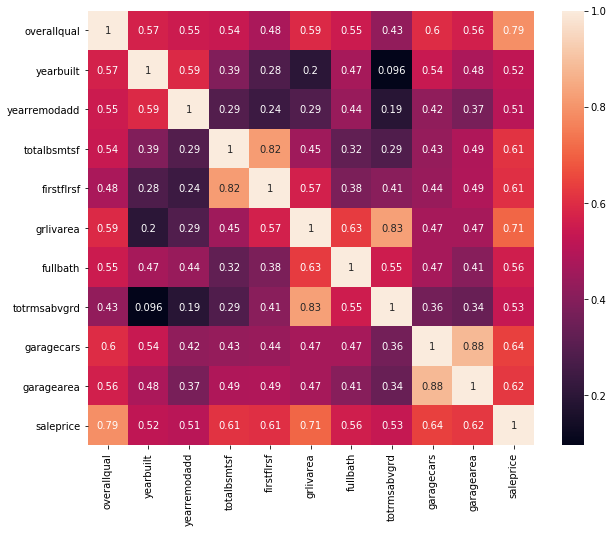

,overallqual,yearbuilt,yearremodadd,totalbsmtsf,grlivarea,fullbath,garagecars,saleprice
overallqual,1.000000,0.572323,0.550684,0.537808,0.593007,0.550600,0.600671,0.790982
yearbuilt,0.572323,1.000000,0.592855,0.391452,0.199010,0.468271,0.537850,0.522897
yearremodadd,0.550684,0.592855,1.000000,0.291066,0.287389,0.439046,0.420622,0.507101
totalbsmtsf,0.537808,0.391452,0.291066,1.000000,0.454868,0.323722,0.434585,0.613581
grlivarea,0.593007,0.199010,0.287389,0.454868,1.000000,0.630012,0.467247,0.708624
fullbath,0.550600,0.468271,0.439046,0.323722,0.630012,1.000000,0.469672,0.560664
garagecars,0.600671,0.537850,0.420622,0.434585,0.467247,0.469672,1.000000,0.640409
saleprice,0.790982,0.522897,0.507101,0.613581,0.708624,0.560664,0.640409,1.000000


In [163]:
# Create new DF with only high correlation variables
house_df_rf = house_df[['overallqual', 'yearbuilt', 'yearremodadd', 'totalbsmtsf', 
                        'firstflrsf', 'grlivarea', 'fullbath', 'totrmsabvgrd', 
                        'garagecars', 'garagearea', 'saleprice']]

# Check correlation between variables
plt.figure(figsize=(10,8))
sns.heatmap(house_df_rf.corr(), annot=True)
plt.show()

# Drop variables that are highly correlated with each other
house_df_rf = house_df_rf.drop(['firstflrsf', 'totrmsabvgrd', 'garagearea'], axis=1)
house_df_rf.corr()

In [164]:
# plot distribution of 8 features and comment

# check log transformation, winsorize


# Determine outliers
for col_name in house_df_rf.columns:
    q75, q25 = np.percentile(house_df_rf[col_name], [75 ,25])
    iqr = q75 - q25
    threshold = 2
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)
    print("Number of outliers in " + col_name + " is: {}".format(
        len((np.where((house_df_rf[col_name] > max_val) 
                      | (house_df_rf[col_name] < min_val))[0]))
    ))

Number of outliers in overallqual is: 0
Number of outliers in yearbuilt is: 0
Number of outliers in yearremodadd is: 0
Number of outliers in totalbsmtsf is: 11
Number of outliers in grlivarea is: 18
Number of outliers in fullbath is: 0
Number of outliers in garagecars is: 0
Number of outliers in saleprice is: 38


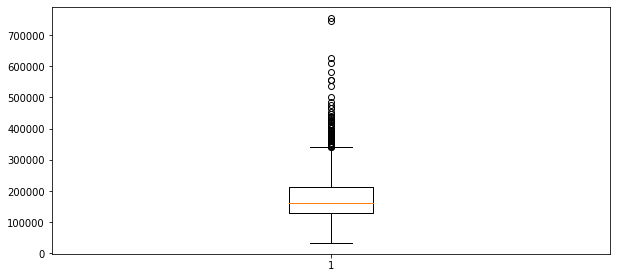

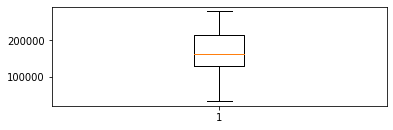

In [165]:
house_df_rf['w_saleprice'] = winsorize(house_df_rf['saleprice'], (0,0.10))

plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.boxplot(house_df_rf['saleprice'])
plt.show()

plt.subplot(2,1,2)
plt.boxplot(house_df_rf['w_saleprice'])
plt.show()

In [166]:
# Standardize remaining features and create model
import statsmodels.api as sm
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn import linear_model

# PCA, component determination
Y = house_df['saleprice']
X = sm.add_constant(scale(house_df_rf.drop('saleprice',1)))

lrm = linear_model.LinearRegression()
lrm.fit(X,Y)
results = sm.OLS(Y,X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     1094.
Date:                Thu, 19 Sep 2019   Prob (F-statistic):               0.00
Time:                        13:48:45   Log-Likelihood:                -17120.
No. Observations:                1460   AIC:                         3.426e+04
Df Residuals:                    1451   BIC:                         3.431e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.809e+05    786.331    230.083      0.0

In [167]:
# Split to train and test sets
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

X_train = sm.add_constant(X_train)
y_preds = lrm.predict(sm.add_constant(X_test))

print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

# Check with cross validation
cv = cross_val_score(lrm, X_train, y_train, cv=10)
print('cross validation, max value: ', cv.max())
print('cross validation, min value: ', cv.min())
print('range of values: ', cv.max() - cv.min())

R-squared of the model in the training set is: 0.864472337996231
-----Test set statistics-----
R-squared of the model in the test set is: 0.8326950999890353
Mean absolute error of the prediction is: 16407.24605446203
Mean squared error of the prediction is: 1123235589.6525836
Root mean squared error of the prediction is: 33514.707064997354
Mean absolute percentage error of the prediction is: 8.846330363208288
cross validation, max value:  0.9243680866150223
cross validation, min value:  0.7730395922309824
range of values:  0.15132849438403995


In [168]:
# Ridge Regression
rreg = linear_model.Lasso(alpha=10**2)
rreg.fit(X_train, y_train)

y_preds_train = rreg.predict(sm.add_constant(X_train))
y_preds_test = rreg.predict(sm.add_constant(X_test))

print("R-squared of the model in the training set is: {}".format(rreg.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(rreg.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

# Check with cross validation
cv = cross_val_score(rreg, X_train, y_train, cv=10)
print('cross validation, max value: ', cv.max())
print('cross validation, min value: ', cv.min())
print('range of values: ', cv.max() - cv.min())

R-squared of the model in the training set is: 0.8650519360104767
-----Test set statistics-----
R-squared of the model in the test set is: 0.8276416640763424
Mean absolute error of the prediction is: 16506.685455902734
Mean squared error of the prediction is: 1157162862.952966
Root mean squared error of the prediction is: 34017.09662732794
Mean absolute percentage error of the prediction is: 8.774408792258681
cross validation, max value:  0.9245248363588444
cross validation, min value:  0.774366285448281
range of values:  0.1501585509105634


In [169]:
# Lasso Regression
lreg = linear_model.Ridge(alpha=10**2)
lreg.fit(X_train, y_train)

y_preds_train = lreg.predict(sm.add_constant(X_train))
y_preds_test = lreg.predict(sm.add_constant(X_test))

print("R-squared of the model in the training set is: {}".format(lreg.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lreg.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

# Check with cross validation
cv = cross_val_score(lreg, X_train, y_train, cv=10)
print('cross validation, max value: ', cv.max())
print('cross validation, min value: ', cv.min())
print('range of values: ', cv.max() - cv.min())

R-squared of the model in the training set is: 0.8586604217329875
-----Test set statistics-----
R-squared of the model in the test set is: 0.8296658634484014
Mean absolute error of the prediction is: 16551.69464001961
Mean squared error of the prediction is: 1143572987.371915
Root mean squared error of the prediction is: 33816.75601490946
Mean absolute percentage error of the prediction is: 9.03226747249955
cross validation, max value:  0.9252003856539615
cross validation, min value:  0.7364445162288482
range of values:  0.18875586942511324


In [170]:
# ElasticNet Regression
enreg = linear_model.ElasticNet(alpha=10**2, l1_ratio=.75)
enreg.fit(X_train, y_train)

y_preds_train = enreg.predict(sm.add_constant(X_train))
y_preds_test = enreg.predict(sm.add_constant(X_test))

print("R-squared of the model in the training set is: {}".format(enreg.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(enreg.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

# Check with cross validation
cv = cross_val_score(lreg, X_train, y_train, cv=10)
print('cross validation, max value: ', cv.max())
print('cross validation, min value: ', cv.min())
print('range of values: ', cv.max() - cv.min())

R-squared of the model in the training set is: 0.223583130129642
-----Test set statistics-----
R-squared of the model in the test set is: 0.21509372840399865
Mean absolute error of the prediction is: 49541.42549485
Mean squared error of the prediction is: 5269628437.304383
Root mean squared error of the prediction is: 72592.20645017193
Mean absolute percentage error of the prediction is: 30.895144921056612
cross validation, max value:  0.9252003856539615
cross validation, min value:  0.7364445162288482
range of values:  0.18875586942511324


Edit:

Based on the various regression models, ElasticNet seems to return the optimal indicator values. With elasticnet loss function set as alpha=1 and l1_ratio=.4 in the model, we get the best indicator values for MAE, MSE, RMSE, and MAPE of the three test set regression models. Indicator values in a simple linear regression model are actually better than any of the three test set regression models, although cross validation reveals that they have extreme variance in the values of each of 10 folds, suggesting that they overfit the data. 

In [171]:
# Introduce interest rate variable
int_rate = pd.read_csv('/Users/JKovach/Downloads/index.csv', encoding = 'ISO-8859-1')

# Isolate the necessary data
int_rate = int_rate[int_rate['Year']>=2006]
int_rate = int_rate[int_rate['Day']==1]
int_rate = int_rate.drop(['Federal Funds Target Rate', 'Federal Funds Upper Target', 
                          'Federal Funds Lower Target', 'Real GDP (Percent Change)'], axis=1)

# Tried to save real GDP column, may explore later

int_rate = int_rate.dropna(how='any')
int_rate.head(24)

,Year,Month,Day,Effective Federal Funds Rate,Unemployment Rate,Inflation Rate
752,2006,1,1,4.29,4.7,2.1
754,2006,2,1,4.49,4.8,2.1
755,2006,3,1,4.59,4.7,2.1
757,2006,4,1,4.79,4.7,2.3
758,2006,5,1,4.94,4.6,2.4
760,2006,6,1,4.99,4.6,2.6
762,2006,7,1,5.24,4.7,2.7
763,2006,8,1,5.25,4.7,2.8
764,2006,9,1,5.25,4.5,2.9
765,2006,10,1,5.25,4.4,2.7


In [183]:
# Merge dataframes
house_df = pd.merge(house_df,
                    int_rate[['Year', 'Month', 'Effective Federal Funds Rate', 
                              'Unemployment Rate', 'Inflation Rate']],
                    left_on = ['yrsold', 'mosold'],
                    right_on = ['Year', 'Month'])

# Verify merge
house_df.iloc[:,35:]

,mosold,yrsold,saleprice,by_alley,has_garage,paved_street,IR1,IR2,IR3,Reg,...,Year_y,Month_y,Effective Federal Funds Rate_y,Unemployment Rate_y,Inflation Rate_y,Year,Month,Effective Federal Funds Rate,Unemployment Rate,Inflation Rate
0,2,2008,208500,0,1,1,0,0,0,1,...,2008,2,2.98,4.9,2.3,2008,2,2.98,4.9,2.3
1,2,2008,129500,0,1,1,0,0,0,1,...,2008,2,2.98,4.9,2.3,2008,2,2.98,4.9,2.3
2,2,2008,171500,0,1,1,0,0,0,1,...,2008,2,2.98,4.9,2.3,2008,2,2.98,4.9,2.3
3,2,2008,120500,0,1,1,0,0,0,1,...,2008,2,2.98,4.9,2.3,2008,2,2.98,4.9,2.3
4,2,2008,113000,0,1,1,0,0,0,1,...,2008,2,2.98,4.9,2.3,2008,2,2.98,4.9,2.3
5,2,2008,226700,0,1,1,0,0,0,1,...,2008,2,2.98,4.9,2.3,2008,2,2.98,4.9,2.3
6,2,2008,146000,1,1,1,0,0,0,1,...,2008,2,2.98,4.9,2.3,2008,2,2.98,4.9,2.3
7,2,2008,149000,0,1,1,0,0,0,1,...,2008,2,2.98,4.9,2.3,2008,2,2.98,4.9,2.3
8,2,2008,145000,0,1,1,0,1,0,0,...,2008,2,2.98,4.9,2.3,2008,2,2.98,4.9,2.3
9,2,2008,184000,0,1,1,1,0,0,0,...,2008,2,2.98,4.9,2.3,2008,2,2.98,4.9,2.3


In [204]:
print(house_df.iloc[:, 35:].corr())
cor_target = abs(cormat['saleprice'])
relevant_features = cor_target[cor_target>0.5]
print(relevant_features)

                                  mosold    yrsold  saleprice  by_alley  \
mosold                          1.000000 -0.145721   0.046432 -0.018130   
yrsold                         -0.145721  1.000000  -0.028923 -0.017571   
saleprice                       0.046432 -0.028923   1.000000 -0.123611   
by_alley                       -0.018130 -0.017571  -0.123611  1.000000   
has_garage                      0.018904 -0.011097   0.236832 -0.048905   
paved_street                    0.003690 -0.025043   0.041036  0.016562   
IR1                             0.032942 -0.035973   0.223284 -0.115356   
IR2                             0.002763  0.004853   0.126096 -0.009526   
IR3                            -0.003746 -0.026006   0.036720  0.012941   
Reg                            -0.032491  0.037933  -0.267672  0.113755   
Abnorml                         0.014467 -0.031291  -0.118069  0.041364   
AdjLand                        -0.001395 -0.042075  -0.050686 -0.013514   
Alloca                   

Based on correlation values in the cell above, we can conclude that the external data is not highly correlated with the target. Instinctively this is surprising, as I would expect the effects of the recession in 2008 to have affect housing prices. It is possible that the recession would have affected home buying in other ways (i.e. the frequency of sale), although I still suspect that due to devalued assets, we should see a correlation in saleprice by year. I test for this below.

In [212]:
print(house_df.columns)
house_df.groupby(['yrsold']).mean().iloc[:, 30:]

Index(['id', 'mssubclass', 'lotfrontage', 'lotarea', 'overallqual',
       'overallcond', 'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf1',
       'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'firstflrsf', 'secondflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd',
       'fireplaces', 'garageyrblt', 'garagecars', 'garagearea', 'wooddecksf',
       'openporchsf', 'enclosedporch', 'threessnporch', 'screenporch',
       'poolarea', 'miscval', 'mosold', 'yrsold', 'saleprice', 'by_alley',
       'has_garage', 'paved_street', 'IR1', 'IR2', 'IR3', 'Reg', 'Abnorml',
       'AdjLand', 'Alloca', 'Family', 'Normal', 'Partial', 'Ex', 'Fa', 'Gd',
       'Po', 'TA', 'age', 'Year_x', 'Month_x',
       'Effective Federal Funds Rate_x', 'Unemployment Rate_x',
       'Inflation Rate_x', 'Year_y', 'Month_y',
       'Effective Federal Funds Rate_y', 'Unemployment Rate_y',
       'Inflation Rate_y', '

,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,saleprice,by_alley,has_garage,paved_street,...,Year_y,Month_y,Effective Federal Funds Rate_y,Unemployment Rate_y,Inflation Rate_y,Year,Month,Effective Federal Funds Rate,Unemployment Rate,Inflation Rate
yrsold,,,,,,,,,,,,,,,,,,,,,
2006,22.726115,2.519108,12.799363,7.697452,16.305732,6.487261,182549.458599,0.060510,0.952229,1.000000,...,2006.0,6.487261,5.025764,4.621338,2.537898,2006.0,6.487261,5.025764,4.621338,2.537898
2007,23.826748,1.580547,15.182371,1.686930,93.708207,6.610942,186063.151976,0.057751,0.948328,0.993921,...,2007.0,6.610942,5.079635,4.603343,2.262614,2007.0,6.610942,5.079635,4.603343,2.262614
2008,21.154605,5.937500,17.108553,3.473684,23.059211,6.546053,177360.838816,0.088816,0.924342,0.993421,...,2008.0,6.546053,1.914441,5.763816,2.346711,2008.0,6.546053,1.914441,5.763816,2.346711
2009,18.529586,4.378698,16.008876,0.000000,20.650888,6.718935,179432.103550,0.059172,0.955621,1.000000,...,2009.0,6.718935,0.164527,9.420118,1.664793,2009.0,6.718935,0.164527,9.420118,1.664793
2010,25.051429,2.182857,13.502857,0.000000,77.451429,4.325714,177393.674286,0.034286,0.937143,0.988571,...,2010.0,4.325714,0.179257,9.683429,0.998286,2010.0,4.325714,0.179257,9.683429,0.998286


In [217]:
import scipy.stats as stats

years = [2007, 2008]
grouped_df = house_df.groupby('yrsold')
for var in ["saleprice"]:
    print("------------------------------------------------")
    print("Comparisons for variable: {}".format(var))
    print("------------------------------------------------")
    for i in range(0, len(years)):
        for j in range(i+1, len(years)):
            print("t-test between groups {0} and {1}:".format(years[i], years[j]))
            print(stats.ttest_ind(
                house_df[house_df['yrsold']==years[i]][var], 
                house_df[house_df['yrsold']==years[j]][var]
            ))

------------------------------------------------
Comparisons for variable: saleprice
------------------------------------------------
t-test between groups 2007 and 2008:
Ttest_indResult(statistic=1.3938379723165053, pvalue=0.16385720241402182)


As we can see from above there is a sizable decrease in sale price between 2007 and 2008. However, based on t-test, this difference is not significant.